## How good is the strategy?

#### Import packages

In [4]:
# import data packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from analysis import *

c:\Users\clayh\Documents\Alameda-Project\analysis.py:14: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  all_bets = all_bets.merge(all_bets["Venue"].str.rsplit(" ", 1, expand=True).rename(columns = {0: "Venue", 1: "Race Number"}), left_index=True, right_index=True, how = 'right')


104.622361282017 337
103.41905200614008 145
29
105.2477588040092
105.2477588040092


#### Manipualte base data

In [5]:
all_bets['midpoint turnover'] = (all_bets['Midpoint Price'] / all_bets['BSP'])
all_bets['midpoint turnover'] = (all_bets['Midpoint Price'] / all_bets['BSP'])
all_bets['profit/loss'] = np.where(all_bets['WIN_LOSE'] == 1, (all_bets['Price'] * 1) - 1, -1)
all_bets['winnings'] = np.where(all_bets['WIN_LOSE'] == 1, (all_bets['Price'] * 1), 0)
all_bets['kelly'] = np.where(all_bets['WIN_LOSE'] == 1, (all_bets['Price'] * 1), 0)
all_bets['implied_probability'] = 1 / all_bets['Price']

#let's filter the data to only observations where the price > midpoint price:
midpoint_strat_profit = all_bets[all_bets['Price'] > all_bets['Midpoint Price']]
profit = sum(all_bets['profit/loss'])
winnings = sum(all_bets['winnings'])
returns = profit / len(all_bets) * 100

# let's group the data by characteristics and see if there is a difference in key metrics:
location_returns = all_bets.groupby('Location')['profit/loss'].sum()
location_returns = location_returns.sort_values(ascending=False)

venue_returns = all_bets.groupby('Venue')['profit/loss'].sum()
venue_returns = venue_returns.sort_values(ascending=False)

race_type_returns = all_bets.groupby('Type')['profit/loss'].sum()
race_type_returns = race_type_returns.sort_values(ascending=False)

#### How good are our bets thus far?

In [6]:
print(f'From a total of {len(all_bets)} bets, betting $1 on every horse yielded a total profit of: ${profit}')
print(f'This equates to a return on investment (${len(all_bets)} base investment) of: {round(returns, 3)} percent.')

display(location_returns)
display(venue_returns)
display(race_type_returns)

From a total of 337 bets, betting $1 on every horse yielded a total profit of: $7.500000000000011
This equates to a return on investment ($337 base investment) of: 2.226 percent.


Location
AUS    34.15
USA   -26.65
Name: profit/loss, dtype: float64

Venue
Menangle            18.50
Gawler               9.70
Shepparton           8.25
Mackay               7.80
Albion Park          7.60
Sandown              6.00
Hobart               6.00
Warragul             5.85
Ballarat             5.70
Warwick Farm         5.50
Bendigo              5.50
Richmond             4.50
Addington            4.50
Sunshine Coast       3.65
Werribee             2.60
Rosehill             2.00
Rockhampton          1.85
Newcastle            1.50
Hawkesbury           1.20
The Meadows          1.05
Wyong                1.00
Darwin               0.70
Redcliffe            0.50
Delta Downs          0.50
Wagga                0.45
Remington Park       0.10
Cannington          -0.05
Angle Park          -0.45
Traralgon           -0.50
Bathurst            -0.50
Nowra               -1.00
Belmont             -1.00
Casino              -1.00
Mornington          -1.00
Mount Gambier       -1.00
Tamworth            -1.00
Geraldton           -1.00
Ascot               -1.45
Townsv

Type
RaceType.TROT_RACE         27.45
RaceType.GREYHOUND_RACE     4.90
RaceType.HORSE_RACE       -24.85
Name: profit/loss, dtype: float64

#### How indicative of the BSP is the midpoint price?

On average the midpoint price is $-1483.267 off from the BSP


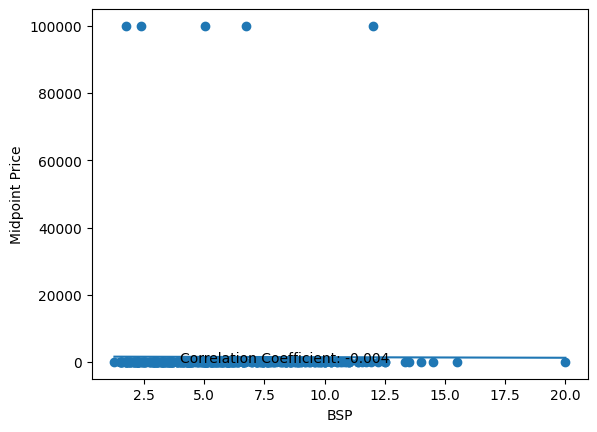

In [7]:
# Let's calculate how far off the midpoint price is from BSP
all_bets['midpoint difference'] = all_bets['BSP'] - all_bets['Midpoint Price']
sum(all_bets['midpoint difference'])

# lets plot the correlation of the BSp with the midpoint price in the all_bets df using matplot lib:
plt.scatter(all_bets['BSP'], all_bets['Midpoint Price'])
plt.xlabel('BSP')
plt.ylabel('Midpoint Price')
plt.plot(np.unique(all_bets['BSP']), np.poly1d(np.polyfit(all_bets['BSP'], all_bets['Midpoint Price'], 1))(np.unique(all_bets['BSP'])))
plt.text(4, 1.5, f'Correlation Coefficient: {round(np.corrcoef(all_bets["BSP"], all_bets["Midpoint Price"])[0,1], 3)}')
print(f'On average the midpoint price is ${round(np.mean(all_bets["midpoint difference"]), 3)} off from the BSP')

#### How indicative of the BSP is the Betr price?

On average the betr price is $-0.03 off from the BSP


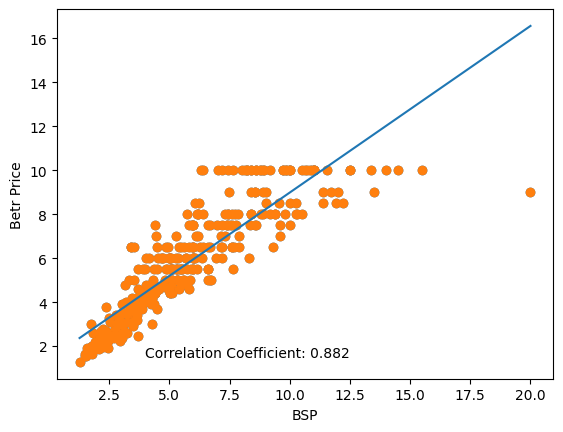

In [8]:
all_bets['betr difference'] = all_bets['BSP'] - all_bets['Price']
sum(all_bets['betr difference'])

# lets plot the correlation of the BSP with the price in the all_bets df using matplot lib:
plt.scatter(all_bets['BSP'], all_bets['Price'])
plt.scatter(all_bets['BSP'], all_bets['Price'])
plt.xlabel('BSP')
plt.ylabel('Betr Price')
plt.plot(np.unique(all_bets['BSP']), np.poly1d(np.polyfit(all_bets['BSP'], all_bets['Price'], 1))(np.unique(all_bets['BSP'])))
plt.text(4, 1.5, f'Correlation Coefficient: {round(np.corrcoef(all_bets["BSP"], all_bets["Price"])[0,1], 3)}')
print(f'On average the betr price is ${round(np.mean(all_bets["betr difference"]), 3)} off from the BSP')

#### How good would of betting with the Kelly Criterion been?

Thus far we have assumed we made \\$1 bets for every horse - but what if the bet size was a function of the implied probability we derive from the price. The below code sees how well we would of done using the kelly criterion for stake sizes assuming we initially placed \\$100 in. 

Text(0, 1200, 'initial stake: $100')

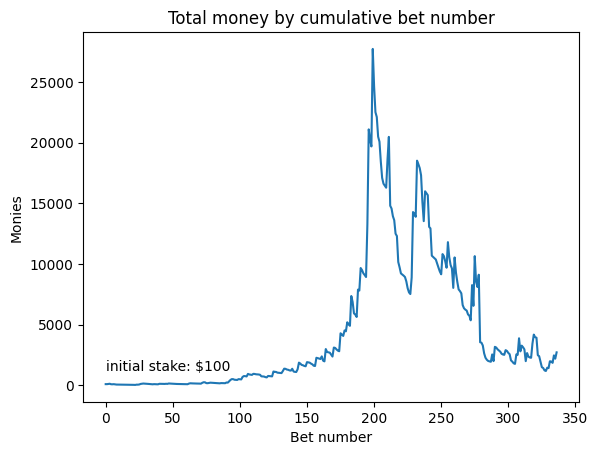

In [9]:
initial_stake = 100
bets = len(all_bets)
monies_array = [initial_stake]

def kelly_fraction(prob, prop_bet_gained):
  return ((prob) - ((1 - prob)) / prop_bet_gained) # need to check correct formula two sites differerd.

for bet in range(1,bets):
    index = bet - 1 
    prob = all_bets['implied_probability'][index]
    price = all_bets['Price'][index]
    prop_bet_gained = (price*1) /1
    kelly_frac = kelly_fraction(prob, prop_bet_gained)
    kelly = kelly_frac * monies_array[-1]

    if all_bets['WIN_LOSE'][index] == 1:
        total_purse = monies_array[-1] + (price * kelly)
        monies_array.append(total_purse)
    else:
        total_purse = monies_array[-1] - (kelly)
        monies_array.append(total_purse)

plt.plot(monies_array)
#lets add axis titles and labels:
plt.xlabel('Bet number')
plt.ylabel('Monies')
plt.title('Total money by cumulative bet number')
plt.text(0, 1200, f'initial stake: ${initial_stake}')

### *below is Ben playing around*

#### Profit from all bets- assuming BSP is long run probability. 

In [10]:
print(f'From a total of ({len(all_bets)} bets) the overall turnover for all our bets is: {all_bets.Turnover.mean()}.')
print(f'This would equate to a profit of {round(all_bets.Turnover.mean() * 100 - 100, 3)} percent- (assuming BSP is accurate in long run)')



From a total of (337 bets) the overall turnover for all our bets is: 104.622361282017.
This would equate to a profit of 10362.236 percent- (assuming BSP is accurate in long run)


#### Profit if we had only bet when the price was better than the midpoint price:

In [11]:
print(f'From a total of ({len(midpoint_strat_profit)} bets) the overall turnover for all our bets is: {midpoint_strat_profit.Turnover.mean()}.')
print(f'This equates to a profit of {round(midpoint_strat_profit.Turnover.mean() * 100 - 100, 3)} percent.')

From a total of (310 bets) the overall turnover for all our bets is: 104.03934650702357.
This equates to a profit of 10303.935 percent.
